In [1]:
from spacepy import pycdf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
from mpl_toolkits.mplot3d import axes3d
import matplotlib
import matplotlib.colors as colors
from collections import Counter
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import math
from lmfit.models import GaussianModel
from sklearn import mixture
from matplotlib.colors import LogNorm
from sklearn import cluster

In [2]:
cdf = pycdf.CDF('/Users/mayur/PhD/Cluster_data/C2_CP_PEA_PITCH_SPIN_DEFlux__20030130_003800_20030130_013500_V170624.cdf')
#/disk/user1/mrb2/Cluster_data/... if on linux
for (i, item) in enumerate(cdf, start=0):
    print(i, item, cdf[i])

0 time_tags__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_EPOCH [854]
1 time_tags_DeltaLower__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_FLOAT [854]
2 time_tags_DeltaUpper__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_FLOAT [854]
3 Angle_SR2phi__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_FLOAT [854]
4 Mode_SunpulseRephaseOffset__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_INT4 [854]
5 Mode_Sensor__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_INT4 [854]
6 Mode_SweepMode_HEEA__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_INT4 [854]
7 Mode_Preset_HEEA__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_INT4 [854]
8 Mode_EnergyLevelRange_HEEA__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_INT4 [854, 2]
9 Mode_EnergyMaxMin_HEEA__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_FLOAT [854, 2]
10 Mode_MCPlevel_HEEA__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_INT4 [854]
11 Mode_DataOrigin_HEEA__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_INT4 [854]
12 Mode_SweepMode_LEEA__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_INT4 [854]
13 Mode_Preset_LEEA__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_INT4 [854]
14 Mode_EnergyLevelRange_LEEA__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_INT4 [854,

In [3]:
epoch = cdf[0][...]
data = cdf[26][...]
energy = cdf[20][...]
pa = cdf[23][...]

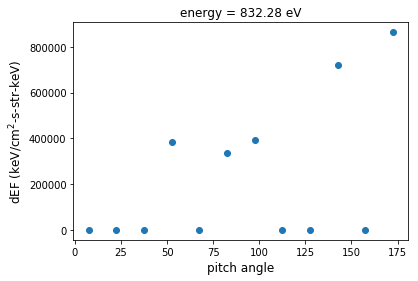

FWHM =  4


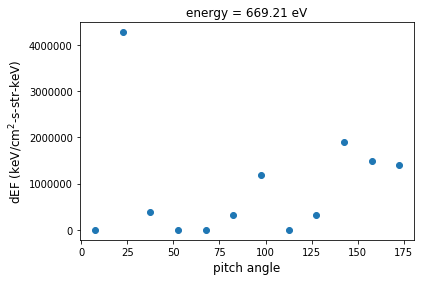

FWHM =  48


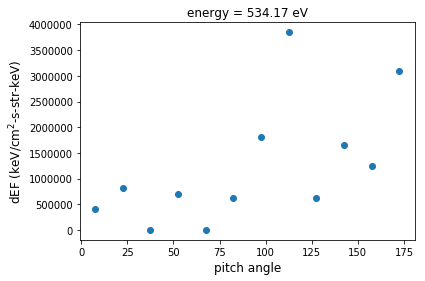

FWHM =  24


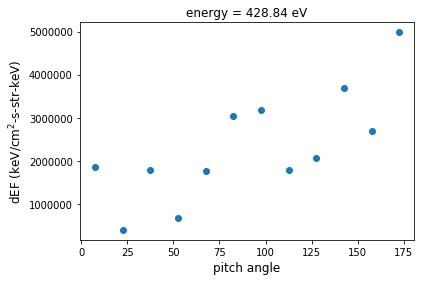

FWHM =  27


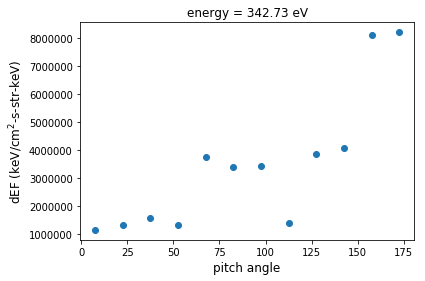

FWHM =  10


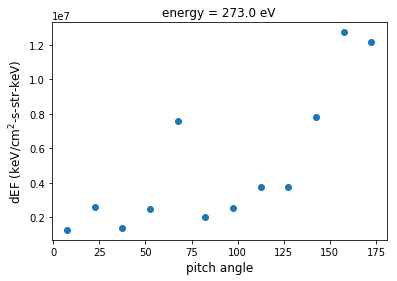

FWHM =  10


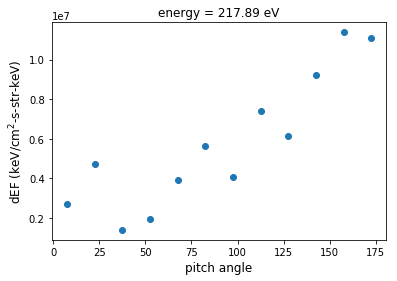

FWHM =  19


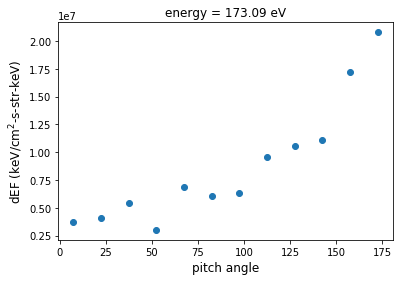

FWHM =  12


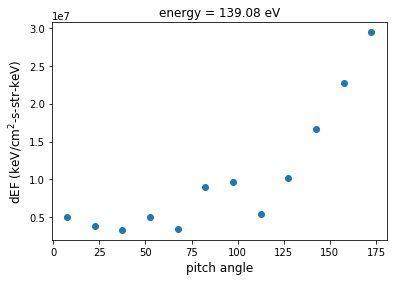

FWHM =  9


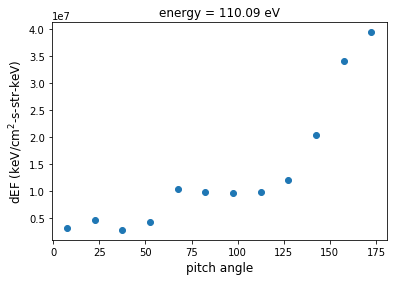

FWHM =  9


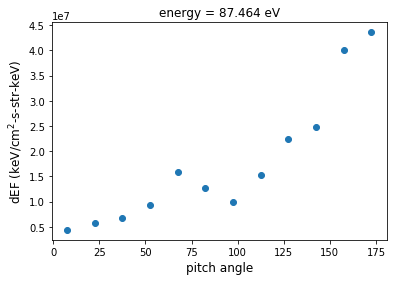

FWHM =  12


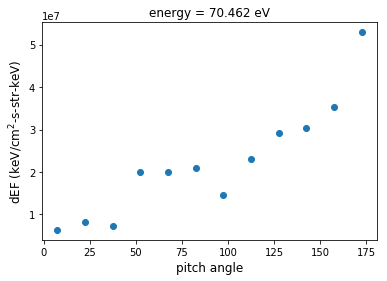

FWHM =  12
[6120.9   4911.    3952.    3156.1   2531.    2030.1   1621.7   1296.2
 1039.9    832.28   669.21   534.17   428.84   342.73   273.     217.89
  173.09   139.08   110.09    87.464   70.462   56.717   47.865   37.66
   30.091   24.348   19.568   15.779   12.543   10.073]


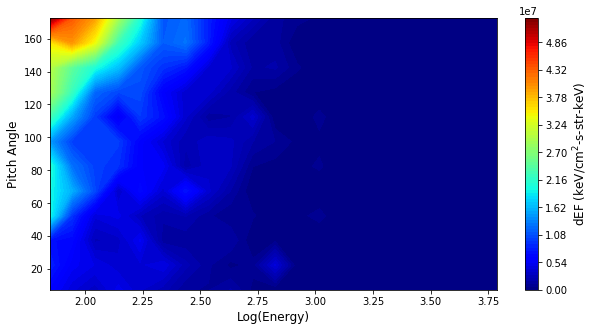

In [4]:
time = 344

#PITCH_SPIN line plotting:

for n in range(9,21):
    y = data[time,0:12,n]
    #plt.plot(pa,y)
    
    t = np.polyfit(pa[0:12], y, 5)
    f = np.poly1d(t)
    pa_new = np.linspace(pa[0], pa[11], 50)
    y_new = f(pa_new)
    #plt.plot(pa[0:12],y,'o', pa_new, y_new)
    plt.scatter(pa[0:12],y)
    plt.title("energy = " + str(energy[time,n]) + " eV")
    plt.xlabel("pitch angle",fontsize=12)
    plt.ylabel("dEF (keV/cm$^{2}$-s-str-keV)",fontsize=12)
    plt.show()
    xs = [x for x in range(50) if y_new[x] > np.max(y_new)/2.0]
    if np.mean(y_new)>0:
        fwhm = np.max(xs)-np.min(xs)
        print('FWHM = ', fwhm)
    
#PITCH_SPIN 2D plotting:
X, Y = np.meshgrid(energy[time,0:21],pa)
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
D = data[time,0:len(pa),0:21]
surf = ax.contourf(np.log10(X), Y, D, 100, cmap=cm.jet)
cbar = fig.colorbar(surf)
cbar.set_label('dEF (keV/cm$^{2}$-s-str-keV)',fontsize=12)
ax.set_ylabel('Pitch Angle',fontsize=12)
ax.set_xlabel('Log(Energy)',fontsize=12)
#ax.set_xlim(0,5)

print(energy[time,0:30])


In [4]:
#breakpoint at 0 degrees

yt_0 = []

    
for n in range(11,30):
    ymean_0 = []
    for t in range(0,len(epoch)):
        y_0 = data[t,0,n]
        ymean_0.append(y_0)
        
        ym_0 = np.mean(ymean_0)
    del ymean_0
    yt_0.append(ym_0)

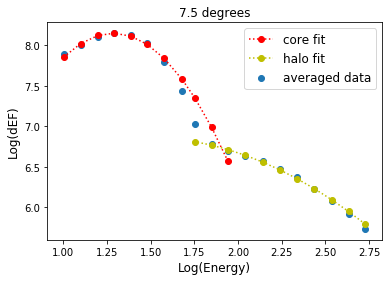

In [5]:
#fit to core
time = 0
x = np.log10(energy[time,23:30])

y = yt_0[12:19]

n = len(x)                          #the number of data
mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[np.max(y),mean,sigma],maxfev=10000)

#fit to halo
x1 = np.log10(energy[time,11:21])

y1 = yt_0[0:10]

n1 = len(x1)                          #the number of data
mean1 = sum(x1 * y1) / sum(y1)
sigma1 = np.sqrt(sum(y1 * (x1 - mean1)**2) / sum(y1))

def gaus1(x1,a1,x01,sigma1):
    return a1*np.exp(-(x1-x01)**2/(2*sigma1**2))

popt1,pcov1 = curve_fit(gaus1,x1,y1,p0=[np.max(y1),mean1,sigma1],maxfev=10000)

plt.scatter(np.log10(energy[0,11:30]),np.log10(yt_0),label='averaged data')
plt.plot(np.log10(energy[time,19:30]),np.log10(gaus(np.log10(energy[time,19:30]),*popt)),'ro:',label='core fit')
plt.plot(np.log10(energy[time,11:22]),np.log10(gaus1(np.log10(energy[time,11:22]),*popt1)),'yo:',label='halo fit')
plt.title("7.5 degrees")
plt.xlabel("Log(Energy)",fontsize=12)
plt.ylabel("Log(dEF)",fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [6]:
#breakpoint at 90 degrees

yt_90 = []

    
for n in range(11,30):
    ymean_90 = []
    for t in range(0,len(epoch)):
        y_90 = data[t,5:7,n]
        ymean_90.append(y_90)
        
        ym_90 = np.mean(ymean_90)
    del ymean_90
    yt_90.append(ym_90)

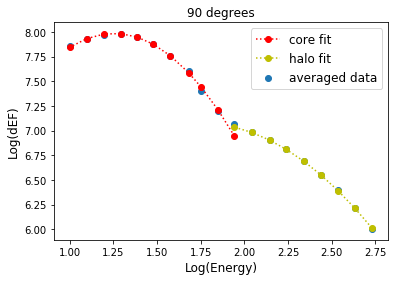

In [19]:
#fit to core
x = np.log10(energy[time,21:30])

y = yt_90[10:19]

n = len(x)                          #the number of data
mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[np.max(y),mean,sigma],maxfev=10000)

#fit to halo
x1 = np.log10(energy[time,11:19])

y1 = yt_90[0:8]

n1 = len(x1)                          #the number of data
mean1 = sum(x1 * y1) / sum(y1)
sigma1 = np.sqrt(sum(y1 * (x1 - mean1)**2) / sum(y1))

def gaus1(x1,a1,x01,sigma1):
    return a1*np.exp(-(x1-x01)**2/(2*sigma1**2))

popt1,pcov1 = curve_fit(gaus1,x1,y1,p0=[np.max(y1),mean1,sigma1],maxfev=10000)

plt.scatter(np.log10(energy[0,11:30]),np.log10(yt_90),label='averaged data')
plt.plot(np.log10(energy[time,19:30]),np.log10(gaus(np.log10(energy[time,19:30]),*popt)),'ro:',label='core fit')
plt.plot(np.log10(energy[time,11:20]),np.log10(gaus1(np.log10(energy[time,11:20]),*popt1)),'yo:',label='halo fit')
plt.title("90 degrees")
plt.xlabel("Log(Energy)",fontsize=12)
plt.ylabel("Log(dEF)",fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [8]:
#breakpoint at 180 degrees

yt_180 = []

    
for n in range(11,30):
    ymean_180 = []
    for t in range(0,len(epoch)):
        y_180 = data[t,11,n]
        ymean_180.append(y_180)
        
        ym_180 = np.mean(ymean_180)
    del ymean_180
    yt_180.append(ym_180)

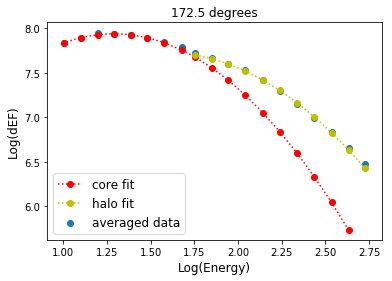

In [9]:
#fit to core
x = np.log10(energy[time,23:30])

y = yt_180[12:19]

n = len(x)                          #the number of data
mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[np.max(y),mean,sigma],maxfev=10000)

#fit to halo
x1 = np.log10(energy[time,11:21])

y1 = yt_180[0:10]

n1 = len(x1)                          #the number of data
mean1 = sum(x1 * y1) / sum(y1)
sigma1 = np.sqrt(sum(y1 * (x1 - mean1)**2) / sum(y1))

def gaus1(x1,a1,x01,sigma1):
    return a1*np.exp(-(x1-x01)**2/(2*sigma1**2))

popt1,pcov1 = curve_fit(gaus1,x1,y1,p0=[np.max(y1),mean1,sigma1],maxfev=10000)

plt.scatter(np.log10(energy[0,11:30]),np.log10(yt_180),label='averaged data')
plt.plot(np.log10(energy[time,12:30]),np.log10(gaus(np.log10(energy[time,12:30]),*popt)),'ro:',label='core fit')
plt.plot(np.log10(energy[time,11:22]),np.log10(gaus1(np.log10(energy[time,11:22]),*popt1)),'yo:',label='halo fit')
plt.title("172.5 degrees")
plt.xlabel("Log(Energy)",fontsize=12)
plt.ylabel("Log(dEF)",fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [18]:
bp_fluxes = []
all_energies = []

for i in range(0,len(epoch)):
    for j in range(14,25):
        flux = data[i,0:12,j]
        
        e = energy[0,j]
        all_energies.append(e)
        
        #if np.max(flux)>0:
        #    flux = (flux-np.min(flux))/(np.max(flux)-np.min(flux))
        
        flux[flux == -1.] = 0.
        
        bp_fluxes.append(flux)
        
#bp_fluxes = StandardScaler().fit_transform(bp_fluxes)
print(np.shape(bp_fluxes))

(9394, 12)


In [6]:
bp = []

from sklearn import cluster
k_means = cluster.KMeans(n_clusters=2)
all_cluster_s = k_means.fit(bp_fluxes)

for (i, item) in enumerate(all_cluster_s.labels_, start=0):
    #print(i, all_energies[i], all_cluster_s.labels_[i])
    if all_cluster_s.labels_[i]<all_cluster_s.labels_[i-1]:
        bp.append(all_energies[i-1])

bp = np.array(bp)
print(Counter(bp))
#print("breakpoint energy as calculated by kmeans = ", stats.mode(bp)[0][0])
print("breakpoint energy as calculated by kmeans = ", np.mean(bp))

Counter({30.091: 854})
breakpoint energy as calculated by kmeans =  30.091002


In [7]:
#compare kmeans to labelling PADs depending on if their energy is above or below bp energy from graphs
var = [1,1,1,1,1,1,1,0,0,0,0,]
var_1 = np.tile(var,len(epoch))
print(np.shape(var_1))
print(metrics.accuracy_score(var_1, all_cluster_s.labels_))

(9394,)
0.11390249095167128


In [19]:
all_fluxes = []
all_values = []

for i in range(0,len(epoch)):
    for j in range(9,21):
        flux = data[i,0:12,j]
        
        flux[flux == -1.] = 0.
        
        all_fluxes.append(flux)
        
#all_fluxes = StandardScaler().fit_transform(all_fluxes)
print(np.shape(all_fluxes))

(10248, 12)


In [23]:
all_k_means = cluster.KMeans(n_clusters=3)
all_clusters = all_k_means.fit(all_fluxes)
all_clusters.labels_[all_clusters.labels_ == 2] = 1
all_clusters.labels_[all_clusters.labels_ == 3] = 1
print(Counter(all_clusters.labels_))

for (i, item) in enumerate(all_clusters.labels_, start=0):
    print(i, all_clusters.labels_[i])

Counter({0: 5526, 1: 4722})
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 1
9 1
10 1
11 1
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 1
21 1
22 1
23 1
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 1
33 1
34 1
35 1
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 1
45 1
46 1
47 1
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 1
57 1
58 1
59 1
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 1
70 1
71 1
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 1
81 1
82 1
83 1
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 1
94 1
95 1
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 1
105 1
106 1
107 1
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 1
117 1
118 1
119 1
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 1
129 1
130 1
131 1
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 1
141 1
142 1
143 1
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 1
153 1
154 1
155 1
156 0
157 0
158 0
159 0
160 0
161 0
162 0
163 0
164 1
165 1
166 1
167 1
168 0
169 0
170 0
171 0
172 0
173 0
174 0
175 1
176 1
177 1
178 1
179 1
18

1784 1
1785 1
1786 1
1787 1
1788 0
1789 0
1790 0
1791 0
1792 0
1793 0
1794 1
1795 1
1796 1
1797 1
1798 1
1799 1
1800 0
1801 0
1802 0
1803 0
1804 0
1805 0
1806 1
1807 1
1808 1
1809 1
1810 1
1811 1
1812 0
1813 0
1814 0
1815 0
1816 0
1817 0
1818 1
1819 1
1820 1
1821 1
1822 1
1823 1
1824 0
1825 0
1826 0
1827 0
1828 0
1829 0
1830 1
1831 1
1832 1
1833 1
1834 1
1835 1
1836 0
1837 0
1838 0
1839 0
1840 0
1841 0
1842 1
1843 1
1844 1
1845 1
1846 1
1847 1
1848 0
1849 0
1850 0
1851 0
1852 0
1853 0
1854 1
1855 1
1856 1
1857 1
1858 1
1859 1
1860 0
1861 0
1862 0
1863 0
1864 0
1865 0
1866 1
1867 1
1868 1
1869 1
1870 1
1871 1
1872 0
1873 0
1874 0
1875 0
1876 0
1877 0
1878 1
1879 1
1880 1
1881 1
1882 1
1883 1
1884 0
1885 0
1886 0
1887 0
1888 0
1889 0
1890 1
1891 1
1892 1
1893 1
1894 1
1895 1
1896 0
1897 0
1898 0
1899 0
1900 0
1901 0
1902 1
1903 1
1904 1
1905 1
1906 1
1907 1
1908 0
1909 0
1910 0
1911 0
1912 0
1913 0
1914 1
1915 1
1916 1
1917 1
1918 1
1919 1
1920 0
1921 0
1922 0
1923 0
1924 0
1925 0
1926 1

3783 0
3784 0
3785 0
3786 0
3787 1
3788 1
3789 1
3790 1
3791 1
3792 0
3793 0
3794 0
3795 0
3796 0
3797 0
3798 1
3799 1
3800 1
3801 1
3802 1
3803 1
3804 0
3805 0
3806 0
3807 0
3808 0
3809 0
3810 1
3811 1
3812 1
3813 1
3814 1
3815 1
3816 0
3817 0
3818 0
3819 0
3820 0
3821 0
3822 1
3823 1
3824 1
3825 1
3826 1
3827 1
3828 0
3829 0
3830 0
3831 0
3832 0
3833 0
3834 1
3835 1
3836 1
3837 1
3838 1
3839 1
3840 0
3841 0
3842 0
3843 0
3844 0
3845 0
3846 1
3847 1
3848 1
3849 1
3850 1
3851 1
3852 0
3853 0
3854 0
3855 0
3856 0
3857 0
3858 1
3859 1
3860 1
3861 1
3862 1
3863 1
3864 0
3865 0
3866 0
3867 0
3868 0
3869 0
3870 1
3871 1
3872 1
3873 1
3874 1
3875 1
3876 0
3877 0
3878 0
3879 0
3880 0
3881 0
3882 1
3883 1
3884 1
3885 1
3886 1
3887 1
3888 0
3889 0
3890 0
3891 0
3892 0
3893 0
3894 1
3895 1
3896 1
3897 1
3898 1
3899 1
3900 0
3901 0
3902 0
3903 0
3904 0
3905 0
3906 1
3907 1
3908 1
3909 1
3910 1
3911 1
3912 0
3913 0
3914 0
3915 0
3916 0
3917 0
3918 1
3919 1
3920 1
3921 1
3922 1
3923 1
3924 0
3925 0

5783 1
5784 0
5785 0
5786 0
5787 0
5788 0
5789 0
5790 1
5791 1
5792 1
5793 1
5794 1
5795 1
5796 0
5797 0
5798 0
5799 0
5800 0
5801 0
5802 1
5803 1
5804 1
5805 1
5806 1
5807 1
5808 0
5809 0
5810 0
5811 0
5812 0
5813 0
5814 0
5815 1
5816 1
5817 1
5818 1
5819 1
5820 0
5821 0
5822 0
5823 0
5824 0
5825 0
5826 1
5827 1
5828 1
5829 1
5830 1
5831 1
5832 0
5833 0
5834 0
5835 0
5836 0
5837 0
5838 1
5839 1
5840 1
5841 1
5842 1
5843 1
5844 0
5845 0
5846 0
5847 0
5848 0
5849 0
5850 1
5851 1
5852 1
5853 1
5854 1
5855 1
5856 0
5857 0
5858 0
5859 0
5860 0
5861 0
5862 0
5863 1
5864 1
5865 1
5866 1
5867 1
5868 0
5869 0
5870 0
5871 0
5872 0
5873 0
5874 0
5875 1
5876 1
5877 1
5878 1
5879 1
5880 0
5881 0
5882 0
5883 0
5884 0
5885 0
5886 1
5887 1
5888 1
5889 1
5890 1
5891 1
5892 0
5893 0
5894 0
5895 0
5896 0
5897 0
5898 0
5899 1
5900 1
5901 1
5902 1
5903 1
5904 0
5905 0
5906 0
5907 0
5908 0
5909 0
5910 1
5911 1
5912 1
5913 1
5914 1
5915 1
5916 0
5917 0
5918 0
5919 0
5920 0
5921 0
5922 1
5923 1
5924 1
5925 1

7782 1
7783 1
7784 1
7785 1
7786 1
7787 1
7788 0
7789 0
7790 0
7791 0
7792 0
7793 0
7794 1
7795 1
7796 1
7797 1
7798 1
7799 1
7800 0
7801 0
7802 0
7803 0
7804 0
7805 0
7806 0
7807 1
7808 1
7809 1
7810 1
7811 1
7812 0
7813 0
7814 0
7815 0
7816 0
7817 0
7818 1
7819 1
7820 1
7821 1
7822 1
7823 1
7824 0
7825 0
7826 0
7827 0
7828 0
7829 0
7830 1
7831 1
7832 1
7833 1
7834 1
7835 1
7836 0
7837 0
7838 0
7839 0
7840 0
7841 0
7842 0
7843 1
7844 1
7845 1
7846 1
7847 1
7848 0
7849 0
7850 0
7851 0
7852 0
7853 0
7854 1
7855 1
7856 1
7857 1
7858 1
7859 1
7860 0
7861 0
7862 0
7863 0
7864 0
7865 0
7866 1
7867 1
7868 1
7869 1
7870 1
7871 1
7872 0
7873 0
7874 0
7875 0
7876 0
7877 0
7878 1
7879 1
7880 1
7881 1
7882 1
7883 1
7884 0
7885 0
7886 0
7887 0
7888 0
7889 0
7890 1
7891 1
7892 1
7893 1
7894 1
7895 1
7896 0
7897 0
7898 0
7899 0
7900 0
7901 0
7902 1
7903 1
7904 1
7905 1
7906 1
7907 1
7908 0
7909 0
7910 0
7911 0
7912 0
7913 0
7914 1
7915 1
7916 1
7917 1
7918 1
7919 1
7920 0
7921 0
7922 0
7923 0
7924 0

9562 1
9563 1
9564 0
9565 0
9566 0
9567 0
9568 0
9569 0
9570 0
9571 1
9572 1
9573 1
9574 1
9575 1
9576 0
9577 0
9578 0
9579 0
9580 0
9581 0
9582 0
9583 1
9584 1
9585 1
9586 1
9587 1
9588 0
9589 0
9590 0
9591 0
9592 0
9593 0
9594 0
9595 1
9596 1
9597 1
9598 1
9599 1
9600 0
9601 0
9602 0
9603 0
9604 0
9605 0
9606 0
9607 0
9608 1
9609 1
9610 1
9611 1
9612 0
9613 0
9614 0
9615 0
9616 0
9617 0
9618 0
9619 1
9620 1
9621 1
9622 1
9623 1
9624 0
9625 0
9626 0
9627 0
9628 0
9629 0
9630 0
9631 1
9632 1
9633 1
9634 1
9635 1
9636 0
9637 0
9638 0
9639 0
9640 0
9641 0
9642 0
9643 1
9644 1
9645 1
9646 1
9647 1
9648 0
9649 0
9650 0
9651 0
9652 0
9653 0
9654 1
9655 1
9656 1
9657 1
9658 1
9659 1
9660 0
9661 0
9662 0
9663 0
9664 0
9665 0
9666 0
9667 1
9668 1
9669 1
9670 1
9671 1
9672 0
9673 0
9674 0
9675 0
9676 0
9677 0
9678 1
9679 1
9680 1
9681 1
9682 1
9683 1
9684 0
9685 0
9686 0
9687 0
9688 0
9689 0
9690 1
9691 1
9692 1
9693 1
9694 1
9695 1
9696 0
9697 0
9698 0
9699 0
9700 0
9701 0
9702 0
9703 1
9704 1

In [24]:
all_fluxes_e = []

for i in range(len(epoch)):
    for j in range(0,12):
        flux_e = data[i,j,9:21]
        flux_e[flux_e == -1.] = 0.
        all_fluxes_e.append(flux_e)
        
#all_fluxes_e = StandardScaler().fit_transform(all_fluxes_e)
np.shape(all_fluxes_e)

(10248, 12)

In [25]:
all_k_means_e = cluster.KMeans(n_clusters=2)
all_clusters_e = all_k_means_e.fit(all_fluxes_e)
print(Counter(all_clusters_e.labels_))

for (i, item) in enumerate(all_clusters_e.labels_, start=0):
    print(i, all_clusters_e.labels_[i])

Counter({0: 8098, 1: 2150})
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 1
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 1
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
131 0
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 0
154 0
155 0
156 0
157 0
158 0
159 0
160 0
161 0
162 0
163 0
164 0
165 0
166 0
167 0
168 0
169 0
170 0
171 0
172 0
173 0
174 0
175 0
176 0
177 0
178 0
179 0
18

1526 0
1527 0
1528 0
1529 0
1530 0
1531 0
1532 0
1533 1
1534 1
1535 1
1536 0
1537 0
1538 0
1539 0
1540 0
1541 0
1542 0
1543 0
1544 0
1545 1
1546 1
1547 1
1548 0
1549 0
1550 0
1551 0
1552 0
1553 0
1554 0
1555 0
1556 0
1557 1
1558 1
1559 1
1560 0
1561 0
1562 0
1563 0
1564 0
1565 0
1566 0
1567 0
1568 0
1569 1
1570 1
1571 1
1572 0
1573 0
1574 0
1575 0
1576 0
1577 0
1578 0
1579 0
1580 0
1581 1
1582 1
1583 1
1584 0
1585 0
1586 0
1587 0
1588 0
1589 0
1590 0
1591 0
1592 0
1593 1
1594 1
1595 1
1596 0
1597 0
1598 0
1599 0
1600 0
1601 0
1602 0
1603 0
1604 0
1605 1
1606 1
1607 1
1608 0
1609 0
1610 0
1611 0
1612 0
1613 0
1614 0
1615 0
1616 0
1617 1
1618 1
1619 1
1620 0
1621 0
1622 0
1623 0
1624 0
1625 0
1626 0
1627 0
1628 0
1629 1
1630 1
1631 1
1632 0
1633 0
1634 0
1635 0
1636 0
1637 0
1638 0
1639 0
1640 0
1641 1
1642 1
1643 1
1644 0
1645 0
1646 0
1647 0
1648 0
1649 0
1650 0
1651 0
1652 1
1653 1
1654 1
1655 1
1656 0
1657 0
1658 0
1659 0
1660 0
1661 0
1662 0
1663 0
1664 0
1665 1
1666 1
1667 1
1668 0

3525 1
3526 1
3527 1
3528 0
3529 0
3530 0
3531 0
3532 0
3533 0
3534 0
3535 0
3536 0
3537 1
3538 1
3539 1
3540 0
3541 0
3542 0
3543 0
3544 0
3545 0
3546 0
3547 0
3548 0
3549 1
3550 1
3551 1
3552 0
3553 0
3554 0
3555 0
3556 0
3557 0
3558 0
3559 0
3560 0
3561 1
3562 1
3563 1
3564 0
3565 0
3566 0
3567 0
3568 0
3569 0
3570 0
3571 0
3572 1
3573 1
3574 1
3575 1
3576 0
3577 0
3578 0
3579 0
3580 0
3581 0
3582 0
3583 0
3584 0
3585 1
3586 1
3587 1
3588 0
3589 0
3590 0
3591 0
3592 0
3593 0
3594 0
3595 0
3596 0
3597 1
3598 1
3599 1
3600 0
3601 0
3602 0
3603 0
3604 0
3605 0
3606 0
3607 0
3608 0
3609 1
3610 1
3611 1
3612 0
3613 0
3614 0
3615 0
3616 0
3617 0
3618 0
3619 0
3620 0
3621 1
3622 1
3623 1
3624 0
3625 0
3626 0
3627 0
3628 0
3629 0
3630 0
3631 0
3632 0
3633 1
3634 1
3635 1
3636 0
3637 0
3638 0
3639 0
3640 0
3641 0
3642 0
3643 0
3644 0
3645 1
3646 1
3647 1
3648 0
3649 0
3650 0
3651 0
3652 0
3653 0
3654 0
3655 0
3656 0
3657 1
3658 1
3659 1
3660 0
3661 0
3662 0
3663 0
3664 0
3665 0
3666 0
3667 0

5025 0
5026 1
5027 1
5028 0
5029 0
5030 0
5031 0
5032 0
5033 0
5034 0
5035 0
5036 0
5037 1
5038 1
5039 1
5040 0
5041 0
5042 0
5043 0
5044 0
5045 0
5046 0
5047 0
5048 0
5049 1
5050 1
5051 1
5052 0
5053 0
5054 0
5055 0
5056 0
5057 0
5058 0
5059 0
5060 0
5061 1
5062 1
5063 1
5064 0
5065 0
5066 0
5067 0
5068 0
5069 0
5070 0
5071 0
5072 0
5073 1
5074 1
5075 1
5076 0
5077 0
5078 0
5079 0
5080 0
5081 0
5082 0
5083 0
5084 0
5085 1
5086 1
5087 1
5088 0
5089 0
5090 0
5091 0
5092 0
5093 0
5094 0
5095 0
5096 0
5097 1
5098 1
5099 1
5100 0
5101 0
5102 0
5103 0
5104 0
5105 0
5106 0
5107 0
5108 0
5109 1
5110 1
5111 1
5112 0
5113 0
5114 0
5115 0
5116 0
5117 0
5118 0
5119 0
5120 0
5121 1
5122 1
5123 1
5124 0
5125 0
5126 0
5127 0
5128 0
5129 0
5130 0
5131 0
5132 0
5133 1
5134 1
5135 1
5136 0
5137 0
5138 0
5139 0
5140 0
5141 0
5142 0
5143 0
5144 0
5145 1
5146 1
5147 1
5148 0
5149 0
5150 0
5151 0
5152 0
5153 0
5154 0
5155 0
5156 0
5157 1
5158 1
5159 1
5160 0
5161 0
5162 0
5163 0
5164 0
5165 0
5166 0
5167 0

6835 0
6836 0
6837 1
6838 1
6839 1
6840 0
6841 0
6842 0
6843 0
6844 0
6845 0
6846 0
6847 0
6848 0
6849 1
6850 1
6851 1
6852 0
6853 0
6854 0
6855 0
6856 0
6857 0
6858 0
6859 0
6860 0
6861 1
6862 1
6863 1
6864 0
6865 0
6866 0
6867 0
6868 0
6869 0
6870 0
6871 0
6872 0
6873 1
6874 1
6875 1
6876 0
6877 0
6878 0
6879 0
6880 0
6881 0
6882 0
6883 0
6884 0
6885 1
6886 1
6887 1
6888 0
6889 0
6890 0
6891 0
6892 0
6893 0
6894 0
6895 0
6896 1
6897 1
6898 1
6899 1
6900 0
6901 0
6902 0
6903 0
6904 0
6905 0
6906 0
6907 0
6908 0
6909 1
6910 1
6911 1
6912 0
6913 0
6914 0
6915 0
6916 0
6917 0
6918 0
6919 0
6920 0
6921 1
6922 1
6923 1
6924 0
6925 0
6926 0
6927 0
6928 0
6929 0
6930 0
6931 0
6932 1
6933 1
6934 1
6935 1
6936 0
6937 0
6938 0
6939 0
6940 0
6941 0
6942 0
6943 0
6944 1
6945 1
6946 1
6947 1
6948 0
6949 0
6950 0
6951 0
6952 0
6953 0
6954 0
6955 0
6956 0
6957 1
6958 1
6959 1
6960 0
6961 0
6962 0
6963 0
6964 0
6965 0
6966 0
6967 0
6968 0
6969 1
6970 1
6971 1
6972 0
6973 0
6974 0
6975 0
6976 0
6977 0

8793 1
8794 1
8795 1
8796 0
8797 0
8798 0
8799 0
8800 0
8801 0
8802 0
8803 0
8804 0
8805 1
8806 1
8807 1
8808 0
8809 0
8810 0
8811 0
8812 0
8813 0
8814 0
8815 0
8816 0
8817 1
8818 1
8819 1
8820 0
8821 0
8822 0
8823 0
8824 0
8825 0
8826 0
8827 0
8828 0
8829 1
8830 1
8831 1
8832 0
8833 0
8834 0
8835 0
8836 0
8837 0
8838 0
8839 0
8840 0
8841 1
8842 1
8843 1
8844 0
8845 0
8846 0
8847 0
8848 0
8849 0
8850 0
8851 0
8852 0
8853 1
8854 1
8855 1
8856 0
8857 0
8858 0
8859 0
8860 0
8861 0
8862 0
8863 0
8864 0
8865 0
8866 1
8867 1
8868 0
8869 0
8870 0
8871 0
8872 0
8873 0
8874 0
8875 0
8876 0
8877 1
8878 1
8879 1
8880 0
8881 0
8882 0
8883 0
8884 0
8885 0
8886 0
8887 0
8888 0
8889 0
8890 1
8891 1
8892 0
8893 0
8894 0
8895 0
8896 0
8897 0
8898 0
8899 0
8900 0
8901 0
8902 1
8903 1
8904 0
8905 0
8906 0
8907 0
8908 0
8909 0
8910 0
8911 0
8912 0
8913 1
8914 1
8915 1
8916 0
8917 0
8918 0
8919 0
8920 0
8921 0
8922 0
8923 0
8924 0
8925 0
8926 1
8927 1
8928 0
8929 0
8930 0
8931 0
8932 0
8933 0
8934 0
8935 0

In [26]:
pa_all = np.array(np.array_split(all_clusters.labels_,len(all_clusters.labels_)/12))

In [27]:
energy_all = np.array(np.array_split(all_clusters_e.labels_,len(all_clusters_e.labels_)/12))

In [28]:
labels_all = []
for k in range(len(epoch)):

    for i in range(12):
        for j in range(12):
            if energy_all[k,i] and pa_all[k,j] == 1:
                strahl = 1
            else:
                strahl = 0
            labels_all.append(strahl)
            
labels_all = np.array(np.array_split(labels_all,len(epoch)))
print(np.shape(labels_all))

final_labels = []
for k in range(len(epoch)):
    final_labels.append(np.array(np.array_split(labels_all[k],12)))
    
final_labels = np.array(final_labels)
print(np.shape(final_labels))

(854, 144)
(854, 12, 12)


In [29]:
print(final_labels[374])#each row = different pa with 0 degrees at top, each column = different energy higher to lower

unique, counts = np.unique(final_labels, return_counts=True)
dict(zip(unique, counts)) #number of 1s and 0s across all times

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1]]


{0: 110615, 1: 12361}

In [18]:
b_labels = final_labels.ravel()

In [19]:
np.savetxt('test1.txt', b_labels, fmt='%d')

In [30]:
halo_count = []
strahl_count = []
gaus_count = []

for k in range(len(epoch)):
    print(k)
    for i in range(12):
        for j in range(12):
            if final_labels[k,i,j] == 0:
                #halo_count.append(data[k,i,9+j])
                halo_count.append(data[k,i,9+j]*((energy[k,9+j]-energy[k,9+(j+1)])/1000)/((energy[k,9+j]/1000)**1.5))
            else:
                #strahl_count.append(data[k,i,7+j])
                strahl_count.append(data[k,i,9+j]*((energy[k,9+j]-energy[k,9+(j+1)])/1000)/((energy[k,9+j]/1000)**1.5))
                
        x = np.log10(energy[k,11:21])
        y = data[k,i,11:21]

        n = len(x)                          #the number of data
        mean = sum(x * y) / sum(y)
        sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))

        def gaus(x,a,x0,sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))
        #print(k)

        popt,pcov = curve_fit(gaus,x,y,p0=[np.max(y),mean,sigma],maxfev=100000)
            
        if gaus(np.log10(energy[k,21]),*popt) < gaus(np.log10(energy[k,20]),*popt):
            for n in range(21,22):
                #gaus_count.append(gaus(np.log10(energy[k,n]),*popt))
                gaus_count.append(gaus(np.log10(energy[k,n]),*popt)*((energy[k,n]-energy[k,n+1])/1000)/((energy[k,n]/1000)**1.5))



0


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

In [17]:
print(np.shape(strahl_count))
print(np.shape(halo_count))
print(np.shape(gaus_count))

(12363,)
(110613,)
(1461,)


In [18]:
extra_halo = []
for k in range(len(epoch)):
    for i in range(12):
        for j in range(6,9):
            #extra_halo.append(data[k,i,j])
            extra_halo.append(data[k,i,j]*((energy[k,j]-energy[k,(j+1)])/1000)/(energy[k,j]/1000)**1.5)

all_halo_count = [*halo_count,*extra_halo]

In [19]:
core_count = []
for k in range(len(epoch)):
    for i in range(12):
        for j in range(21,30):
            #core_count.append(data[k,i,j])
            core_count.append(data[k,i,j]*(np.abs(energy[k,j]-energy[k,(j-1)])/1000)/(energy[k,j]/1000)**1.5)
total_core = np.sum(core_count)-np.sum(gaus_count)

In [20]:
supra_count = []
for k in range(len(epoch)):
    for i in range(12):
        for j in range(6,21):
            #core_count.append(data[k,i,j])
            supra_count.append(data[k,i,j]*((energy[k,j]-energy[k,(j+1)])/1000)/(energy[k,j]/1000)**1.5)
total_supra = np.sum(supra_count)+np.sum(gaus_count)

In [21]:
#strahl/halo ratio in suprathermal range
total_strahl = (np.sum(strahl_count)-len(strahl_count)*np.mean(halo_count))
total_halo = (np.sum(all_halo_count)+(len(strahl_count)*np.mean(halo_count)))

In [22]:
print(total_strahl/total_halo)
print(total_supra/total_core)

0.5321727653303997
0.04339558017458852


In [32]:
%matplotlib qt
X, Y = np.meshgrid(np.log10(energy[0:10,9:21]),pa)
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111,projection='3d')
#ax.scatter(np.log10(X),Y,data[0:10,0:12,9:21],c='r')

for k in range(80):
    for i in range(12):
        for j in range(12):
            if final_labels[k*10,i,j] == 0:
                h = ax.scatter(np.log10(energy[k*10,j+9]),pa[i],data[k*10,i,j+9],c='r')
            else:
                s = ax.scatter(np.log10(energy[k*10,j+9]),pa[i],data[k*10,i,j+9],c='b')
                
ax.legend((h,s),('halo','strahl'))
ax.set_xticks([1.78,2.0,2.3,2.5,2.6,2.7,2.78])
ax.set_xticklabels([60,100,200,300,400,500,600]) #swap log base 10 values of 50,100 etc to 50,100 etc
ax.set_ylabel('Pitch Angle [degrees]')
ax.set_xlabel('Energy [eV]')
ax.set_zlabel('dEF [keV/cm$^{2}$-s-str-keV]')
plt.show()

# Slow Wind

In [33]:
cdf1 = pycdf.CDF('/Users/mayur/PhD/Cluster_data/C2_CP_PEA_PITCH_SPIN_DEFlux__20090208_043300_20090208_061800_V170911.cdf')
#/disk/user1/mrb2/Cluster_data/... if on linux
for (i, item) in enumerate(cdf1, start=0):
    print(i, item, cdf1[i])

0 time_tags__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_EPOCH [1520]
1 time_tags_DeltaLower__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_FLOAT [1520]
2 time_tags_DeltaUpper__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_FLOAT [1520]
3 Angle_SR2phi__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_FLOAT [1520]
4 Mode_SunpulseRephaseOffset__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_INT4 [1520]
5 Mode_Sensor__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_INT4 [1520]
6 Mode_SweepMode_HEEA__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_INT4 [1520]
7 Mode_Preset_HEEA__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_INT4 [1520]
8 Mode_EnergyLevelRange_HEEA__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_INT4 [1520, 2]
9 Mode_EnergyMaxMin_HEEA__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_FLOAT [1520, 2]
10 Mode_MCPlevel_HEEA__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_INT4 [1520]
11 Mode_DataOrigin_HEEA__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_INT4 [1520]
12 Mode_SweepMode_LEEA__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_INT4 [1520]
13 Mode_Preset_LEEA__C2_CP_PEA_PITCH_SPIN_DEFlux CDF_INT4 [1520]
14 Mode_EnergyLevelRange_LEEA__C2_CP_PEA_PITCH_SPIN_DEFlux 

In [34]:
epoch1 = cdf1[0][...]
data1 = cdf1[26][...]
energy1 = cdf1[20][...]
pa1 = cdf1[23][...]

In [35]:
all_fluxes1 = []
all_values1 = []

for i in range(0,len(epoch1)):
    for j in range(10,22):
        flux1 = data1[i,0:12,j]
        
        #if np.max(flux1)>0:
        #    flux1 = (flux1-np.min(flux1))/(np.max(flux1)-np.min(flux1))
        
        flux1[flux1 == -1.] = 0.
        
        all_fluxes1.append(flux1)
        
#all_fluxes1 = StandardScaler().fit_transform(all_fluxes1)
print(np.shape(all_fluxes1))

(18240, 12)


In [36]:
all_clusters1 = all_k_means.predict(all_fluxes1)
all_clusters1[all_clusters1 == 2] = 1
print(Counter(all_clusters1))

for (i, item) in enumerate(all_clusters1, start=0):
    print(i, all_clusters1[i])

Counter({0: 16178, 1: 2062})
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 1
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 1
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 1
47 1
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 1
59 1
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 1
71 1
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 1
83 1
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 1
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 1
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 1
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
131 1
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 0
141 0
142 1
143 1
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 0
154 1
155 1
156 0
157 0
158 0
159 0
160 0
161 0
162 0
163 0
164 0
165 1
166 1
167 1
168 0
169 0
170 0
171 0
172 0
173 0
174 0
175 0
176 0
177 0
178 1
179 1
1

1751 1
1752 0
1753 0
1754 0
1755 0
1756 0
1757 0
1758 0
1759 0
1760 0
1761 0
1762 1
1763 1
1764 0
1765 0
1766 0
1767 0
1768 0
1769 0
1770 0
1771 0
1772 0
1773 0
1774 1
1775 1
1776 0
1777 0
1778 0
1779 0
1780 0
1781 0
1782 0
1783 0
1784 0
1785 0
1786 1
1787 1
1788 0
1789 0
1790 0
1791 0
1792 0
1793 0
1794 0
1795 0
1796 0
1797 0
1798 1
1799 1
1800 0
1801 0
1802 0
1803 0
1804 0
1805 0
1806 0
1807 0
1808 0
1809 1
1810 1
1811 1
1812 0
1813 0
1814 0
1815 0
1816 0
1817 0
1818 0
1819 0
1820 0
1821 0
1822 0
1823 1
1824 0
1825 0
1826 0
1827 0
1828 0
1829 0
1830 0
1831 0
1832 0
1833 0
1834 1
1835 1
1836 0
1837 0
1838 0
1839 0
1840 0
1841 0
1842 0
1843 0
1844 1
1845 0
1846 0
1847 1
1848 0
1849 0
1850 0
1851 0
1852 0
1853 0
1854 0
1855 0
1856 0
1857 1
1858 1
1859 1
1860 0
1861 0
1862 0
1863 0
1864 0
1865 0
1866 0
1867 0
1868 0
1869 0
1870 0
1871 1
1872 0
1873 0
1874 0
1875 0
1876 0
1877 0
1878 0
1879 0
1880 0
1881 1
1882 1
1883 1
1884 0
1885 0
1886 0
1887 0
1888 0
1889 0
1890 0
1891 0
1892 0
1893 0

3647 1
3648 0
3649 0
3650 0
3651 0
3652 0
3653 0
3654 0
3655 0
3656 0
3657 0
3658 1
3659 1
3660 0
3661 0
3662 0
3663 0
3664 0
3665 0
3666 0
3667 0
3668 0
3669 1
3670 1
3671 1
3672 0
3673 0
3674 0
3675 0
3676 0
3677 0
3678 0
3679 0
3680 0
3681 0
3682 1
3683 1
3684 0
3685 0
3686 0
3687 0
3688 0
3689 0
3690 0
3691 0
3692 0
3693 1
3694 1
3695 1
3696 0
3697 0
3698 0
3699 0
3700 0
3701 0
3702 0
3703 0
3704 0
3705 0
3706 0
3707 1
3708 0
3709 0
3710 0
3711 0
3712 0
3713 0
3714 0
3715 0
3716 0
3717 0
3718 1
3719 1
3720 0
3721 0
3722 0
3723 0
3724 0
3725 0
3726 0
3727 0
3728 0
3729 0
3730 1
3731 1
3732 0
3733 0
3734 0
3735 0
3736 0
3737 0
3738 0
3739 0
3740 0
3741 0
3742 1
3743 1
3744 0
3745 0
3746 0
3747 0
3748 0
3749 0
3750 0
3751 0
3752 0
3753 1
3754 1
3755 1
3756 0
3757 0
3758 0
3759 0
3760 0
3761 0
3762 0
3763 0
3764 0
3765 0
3766 1
3767 1
3768 0
3769 0
3770 0
3771 0
3772 0
3773 0
3774 0
3775 0
3776 0
3777 0
3778 1
3779 1
3780 0
3781 0
3782 0
3783 0
3784 0
3785 0
3786 0
3787 0
3788 0
3789 1

5647 0
5648 0
5649 0
5650 0
5651 1
5652 0
5653 0
5654 0
5655 0
5656 0
5657 0
5658 0
5659 0
5660 0
5661 0
5662 0
5663 1
5664 0
5665 0
5666 0
5667 0
5668 0
5669 0
5670 0
5671 0
5672 0
5673 0
5674 0
5675 1
5676 0
5677 0
5678 0
5679 0
5680 0
5681 0
5682 0
5683 0
5684 0
5685 0
5686 1
5687 1
5688 0
5689 0
5690 0
5691 0
5692 0
5693 0
5694 0
5695 0
5696 0
5697 0
5698 1
5699 1
5700 0
5701 0
5702 0
5703 0
5704 0
5705 0
5706 0
5707 0
5708 0
5709 1
5710 0
5711 1
5712 0
5713 0
5714 0
5715 0
5716 0
5717 0
5718 0
5719 0
5720 0
5721 0
5722 0
5723 1
5724 0
5725 0
5726 0
5727 0
5728 0
5729 0
5730 0
5731 0
5732 0
5733 0
5734 1
5735 1
5736 0
5737 0
5738 0
5739 0
5740 0
5741 0
5742 0
5743 0
5744 0
5745 0
5746 0
5747 1
5748 0
5749 0
5750 0
5751 0
5752 0
5753 0
5754 0
5755 0
5756 0
5757 0
5758 0
5759 1
5760 0
5761 0
5762 0
5763 0
5764 0
5765 0
5766 0
5767 0
5768 0
5769 0
5770 1
5771 1
5772 0
5773 0
5774 0
5775 0
5776 0
5777 0
5778 0
5779 0
5780 0
5781 0
5782 1
5783 1
5784 0
5785 0
5786 0
5787 0
5788 0
5789 0

7396 0
7397 0
7398 0
7399 0
7400 0
7401 0
7402 0
7403 1
7404 0
7405 0
7406 0
7407 0
7408 0
7409 0
7410 0
7411 0
7412 0
7413 0
7414 0
7415 1
7416 0
7417 0
7418 0
7419 0
7420 0
7421 0
7422 0
7423 0
7424 0
7425 0
7426 0
7427 1
7428 0
7429 0
7430 0
7431 0
7432 0
7433 0
7434 0
7435 0
7436 0
7437 0
7438 0
7439 1
7440 0
7441 0
7442 0
7443 0
7444 0
7445 0
7446 0
7447 0
7448 0
7449 0
7450 0
7451 1
7452 0
7453 0
7454 0
7455 0
7456 0
7457 0
7458 0
7459 0
7460 0
7461 0
7462 1
7463 1
7464 0
7465 0
7466 0
7467 0
7468 0
7469 0
7470 0
7471 0
7472 0
7473 0
7474 1
7475 1
7476 0
7477 0
7478 0
7479 0
7480 0
7481 0
7482 0
7483 0
7484 0
7485 0
7486 0
7487 1
7488 0
7489 0
7490 0
7491 0
7492 0
7493 0
7494 0
7495 0
7496 0
7497 1
7498 1
7499 1
7500 0
7501 0
7502 0
7503 0
7504 0
7505 0
7506 0
7507 0
7508 0
7509 0
7510 0
7511 0
7512 0
7513 0
7514 0
7515 0
7516 0
7517 0
7518 0
7519 0
7520 0
7521 1
7522 0
7523 1
7524 0
7525 0
7526 0
7527 0
7528 0
7529 0
7530 0
7531 0
7532 0
7533 0
7534 0
7535 1
7536 0
7537 0
7538 0

9396 0
9397 0
9398 0
9399 0
9400 0
9401 0
9402 0
9403 0
9404 0
9405 0
9406 0
9407 1
9408 0
9409 0
9410 0
9411 0
9412 0
9413 0
9414 0
9415 0
9416 0
9417 0
9418 1
9419 1
9420 0
9421 0
9422 0
9423 0
9424 0
9425 0
9426 0
9427 0
9428 0
9429 0
9430 0
9431 1
9432 0
9433 0
9434 0
9435 0
9436 0
9437 0
9438 0
9439 0
9440 0
9441 0
9442 0
9443 1
9444 0
9445 0
9446 0
9447 0
9448 0
9449 0
9450 0
9451 0
9452 0
9453 0
9454 0
9455 1
9456 0
9457 0
9458 0
9459 0
9460 0
9461 0
9462 0
9463 0
9464 0
9465 0
9466 0
9467 1
9468 0
9469 0
9470 0
9471 0
9472 0
9473 0
9474 0
9475 0
9476 0
9477 0
9478 1
9479 1
9480 0
9481 0
9482 0
9483 0
9484 0
9485 0
9486 0
9487 0
9488 0
9489 0
9490 1
9491 1
9492 0
9493 0
9494 0
9495 0
9496 0
9497 0
9498 0
9499 0
9500 0
9501 0
9502 1
9503 1
9504 0
9505 0
9506 0
9507 0
9508 0
9509 0
9510 0
9511 0
9512 0
9513 0
9514 0
9515 1
9516 0
9517 0
9518 0
9519 0
9520 0
9521 0
9522 0
9523 0
9524 0
9525 0
9526 0
9527 1
9528 0
9529 0
9530 0
9531 0
9532 0
9533 0
9534 0
9535 0
9536 0
9537 1
9538 0

11395 0
11396 0
11397 0
11398 0
11399 1
11400 0
11401 0
11402 0
11403 0
11404 0
11405 0
11406 0
11407 0
11408 0
11409 0
11410 0
11411 1
11412 0
11413 0
11414 0
11415 0
11416 0
11417 0
11418 0
11419 0
11420 0
11421 0
11422 0
11423 1
11424 0
11425 0
11426 0
11427 0
11428 0
11429 0
11430 0
11431 0
11432 0
11433 0
11434 0
11435 1
11436 0
11437 0
11438 0
11439 0
11440 0
11441 0
11442 0
11443 0
11444 0
11445 0
11446 0
11447 1
11448 0
11449 0
11450 0
11451 0
11452 0
11453 0
11454 0
11455 0
11456 0
11457 0
11458 0
11459 1
11460 0
11461 0
11462 0
11463 0
11464 0
11465 0
11466 0
11467 0
11468 0
11469 0
11470 0
11471 0
11472 0
11473 0
11474 0
11475 0
11476 0
11477 0
11478 0
11479 0
11480 0
11481 0
11482 0
11483 1
11484 0
11485 0
11486 0
11487 0
11488 0
11489 0
11490 0
11491 0
11492 0
11493 0
11494 0
11495 1
11496 0
11497 0
11498 0
11499 0
11500 0
11501 0
11502 0
11503 0
11504 0
11505 0
11506 0
11507 1
11508 0
11509 0
11510 0
11511 0
11512 0
11513 0
11514 0
11515 0
11516 0
11517 0
11518 0
11519 1


13395 0
13396 0
13397 0
13398 0
13399 0
13400 0
13401 0
13402 0
13403 1
13404 0
13405 0
13406 0
13407 0
13408 0
13409 0
13410 0
13411 0
13412 0
13413 0
13414 0
13415 1
13416 0
13417 0
13418 0
13419 0
13420 0
13421 0
13422 0
13423 0
13424 0
13425 0
13426 0
13427 0
13428 0
13429 0
13430 0
13431 0
13432 0
13433 0
13434 0
13435 0
13436 0
13437 0
13438 0
13439 1
13440 0
13441 0
13442 0
13443 0
13444 0
13445 0
13446 0
13447 0
13448 0
13449 0
13450 0
13451 1
13452 0
13453 0
13454 0
13455 0
13456 0
13457 0
13458 0
13459 0
13460 0
13461 0
13462 0
13463 1
13464 0
13465 0
13466 0
13467 0
13468 0
13469 0
13470 0
13471 0
13472 0
13473 0
13474 0
13475 1
13476 0
13477 0
13478 0
13479 0
13480 0
13481 0
13482 0
13483 0
13484 0
13485 0
13486 1
13487 1
13488 0
13489 0
13490 0
13491 0
13492 0
13493 0
13494 0
13495 0
13496 0
13497 0
13498 1
13499 1
13500 0
13501 0
13502 0
13503 0
13504 0
13505 0
13506 0
13507 0
13508 0
13509 0
13510 0
13511 0
13512 0
13513 0
13514 0
13515 0
13516 0
13517 0
13518 0
13519 0


15394 0
15395 1
15396 0
15397 0
15398 0
15399 0
15400 0
15401 0
15402 0
15403 0
15404 0
15405 0
15406 1
15407 1
15408 0
15409 0
15410 0
15411 0
15412 0
15413 0
15414 0
15415 0
15416 0
15417 0
15418 0
15419 1
15420 0
15421 0
15422 0
15423 0
15424 0
15425 0
15426 0
15427 0
15428 0
15429 0
15430 0
15431 1
15432 0
15433 0
15434 0
15435 0
15436 0
15437 0
15438 0
15439 0
15440 0
15441 0
15442 0
15443 1
15444 0
15445 0
15446 0
15447 0
15448 0
15449 0
15450 0
15451 0
15452 0
15453 0
15454 0
15455 1
15456 0
15457 0
15458 0
15459 0
15460 0
15461 0
15462 0
15463 0
15464 0
15465 0
15466 0
15467 1
15468 0
15469 0
15470 0
15471 0
15472 0
15473 0
15474 0
15475 0
15476 0
15477 0
15478 0
15479 1
15480 0
15481 0
15482 0
15483 0
15484 0
15485 0
15486 0
15487 0
15488 0
15489 0
15490 0
15491 1
15492 0
15493 0
15494 0
15495 0
15496 0
15497 0
15498 0
15499 0
15500 0
15501 1
15502 0
15503 1
15504 0
15505 0
15506 0
15507 0
15508 0
15509 0
15510 0
15511 0
15512 0
15513 0
15514 0
15515 1
15516 0
15517 0
15518 0


17394 0
17395 0
17396 0
17397 0
17398 0
17399 1
17400 0
17401 0
17402 0
17403 0
17404 0
17405 0
17406 0
17407 0
17408 0
17409 0
17410 0
17411 1
17412 0
17413 0
17414 0
17415 0
17416 0
17417 0
17418 0
17419 0
17420 0
17421 0
17422 0
17423 1
17424 0
17425 0
17426 0
17427 0
17428 0
17429 0
17430 0
17431 0
17432 0
17433 0
17434 0
17435 1
17436 0
17437 0
17438 0
17439 0
17440 0
17441 0
17442 0
17443 0
17444 0
17445 0
17446 1
17447 1
17448 0
17449 0
17450 0
17451 0
17452 0
17453 0
17454 0
17455 0
17456 0
17457 0
17458 0
17459 1
17460 0
17461 0
17462 0
17463 0
17464 0
17465 0
17466 0
17467 0
17468 0
17469 0
17470 0
17471 1
17472 0
17473 0
17474 0
17475 0
17476 0
17477 0
17478 0
17479 0
17480 0
17481 0
17482 0
17483 1
17484 0
17485 0
17486 0
17487 0
17488 0
17489 0
17490 0
17491 0
17492 0
17493 0
17494 0
17495 1
17496 0
17497 0
17498 0
17499 0
17500 0
17501 0
17502 0
17503 0
17504 0
17505 0
17506 0
17507 1
17508 0
17509 0
17510 0
17511 0
17512 0
17513 0
17514 0
17515 0
17516 0
17517 0
17518 0


In [37]:
all_fluxes_e1 = []

for i in range(len(epoch1)):
    for j in range(0,12):
        flux_e1 = data1[i,j,10:22]
        flux_e1[flux_e1 == -1.] = 0.
        all_fluxes_e1.append(flux_e1)
        
#all_fluxes_e1 = StandardScaler().fit_transform(all_fluxes_e1)
np.shape(all_fluxes_e1)

(18240, 12)

In [40]:
all_k_means_e3 = cluster.KMeans(n_clusters=3)
all_clusters_e3 = all_k_means_e3.fit(all_fluxes_e)

all_clusters_e1 = all_k_means_e3.predict(all_fluxes_e1)
all_clusters_e1[all_clusters_e1 == 2] = 1
print(Counter(all_clusters_e1))

for (i, item) in enumerate(all_clusters_e1, start=0):
    print(i, all_clusters_e1[i])

Counter({0: 17580, 1: 660})
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 1
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 1
45 0
46 0
47 1
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 1
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 1
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 1
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 1
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
131 0
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 0
141 0
142 0
143 1
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 1
154 0
155 1
156 0
157 0
158 0
159 0
160 0
161 0
162 0
163 0
164 0
165 0
166 0
167 0
168 0
169 0
170 0
171 0
172 0
173 0
174 0
175 0
176 0
177 0
178 0
179 0
18

2128 0
2129 0
2130 0
2131 0
2132 0
2133 1
2134 0
2135 0
2136 0
2137 0
2138 0
2139 0
2140 0
2141 0
2142 0
2143 0
2144 0
2145 1
2146 1
2147 1
2148 0
2149 0
2150 0
2151 0
2152 0
2153 0
2154 0
2155 0
2156 0
2157 1
2158 0
2159 1
2160 0
2161 0
2162 0
2163 0
2164 0
2165 0
2166 0
2167 0
2168 0
2169 0
2170 0
2171 1
2172 0
2173 0
2174 0
2175 0
2176 0
2177 0
2178 0
2179 0
2180 0
2181 0
2182 0
2183 0
2184 0
2185 0
2186 0
2187 0
2188 0
2189 0
2190 0
2191 0
2192 0
2193 1
2194 1
2195 1
2196 0
2197 0
2198 0
2199 0
2200 0
2201 0
2202 0
2203 0
2204 0
2205 0
2206 1
2207 1
2208 0
2209 0
2210 0
2211 0
2212 0
2213 0
2214 0
2215 0
2216 1
2217 0
2218 1
2219 1
2220 0
2221 0
2222 0
2223 0
2224 0
2225 0
2226 0
2227 0
2228 0
2229 1
2230 0
2231 1
2232 0
2233 0
2234 0
2235 0
2236 0
2237 0
2238 0
2239 0
2240 0
2241 0
2242 0
2243 1
2244 0
2245 0
2246 0
2247 0
2248 0
2249 0
2250 0
2251 0
2252 0
2253 1
2254 1
2255 1
2256 0
2257 0
2258 0
2259 0
2260 0
2261 0
2262 0
2263 0
2264 0
2265 1
2266 1
2267 0
2268 0
2269 0
2270 0

4149 1
4150 0
4151 1
4152 0
4153 0
4154 0
4155 0
4156 0
4157 0
4158 0
4159 0
4160 0
4161 0
4162 1
4163 1
4164 0
4165 0
4166 0
4167 0
4168 0
4169 0
4170 0
4171 0
4172 0
4173 0
4174 1
4175 1
4176 0
4177 0
4178 0
4179 0
4180 0
4181 0
4182 0
4183 0
4184 0
4185 0
4186 1
4187 1
4188 0
4189 0
4190 0
4191 0
4192 0
4193 0
4194 0
4195 0
4196 0
4197 1
4198 0
4199 1
4200 0
4201 0
4202 0
4203 0
4204 0
4205 0
4206 0
4207 0
4208 0
4209 0
4210 1
4211 1
4212 0
4213 0
4214 0
4215 0
4216 0
4217 0
4218 0
4219 0
4220 0
4221 1
4222 1
4223 1
4224 0
4225 0
4226 0
4227 0
4228 0
4229 0
4230 0
4231 0
4232 0
4233 0
4234 0
4235 0
4236 0
4237 0
4238 0
4239 0
4240 0
4241 0
4242 0
4243 0
4244 0
4245 0
4246 0
4247 1
4248 0
4249 0
4250 0
4251 0
4252 0
4253 0
4254 0
4255 0
4256 0
4257 0
4258 0
4259 1
4260 0
4261 0
4262 0
4263 0
4264 0
4265 0
4266 0
4267 0
4268 0
4269 0
4270 0
4271 1
4272 0
4273 0
4274 0
4275 0
4276 0
4277 0
4278 0
4279 0
4280 0
4281 1
4282 1
4283 1
4284 0
4285 0
4286 0
4287 0
4288 0
4289 0
4290 0
4291 0

6149 0
6150 0
6151 0
6152 0
6153 0
6154 0
6155 0
6156 0
6157 0
6158 0
6159 0
6160 0
6161 0
6162 0
6163 0
6164 0
6165 0
6166 0
6167 1
6168 0
6169 0
6170 0
6171 0
6172 0
6173 0
6174 0
6175 0
6176 0
6177 0
6178 0
6179 0
6180 0
6181 0
6182 0
6183 0
6184 0
6185 0
6186 0
6187 0
6188 0
6189 0
6190 1
6191 0
6192 0
6193 0
6194 0
6195 0
6196 0
6197 0
6198 0
6199 0
6200 0
6201 1
6202 0
6203 1
6204 0
6205 0
6206 0
6207 0
6208 0
6209 0
6210 0
6211 0
6212 0
6213 0
6214 0
6215 0
6216 0
6217 0
6218 0
6219 0
6220 0
6221 0
6222 0
6223 0
6224 0
6225 0
6226 0
6227 0
6228 0
6229 0
6230 0
6231 0
6232 0
6233 0
6234 0
6235 0
6236 0
6237 0
6238 0
6239 0
6240 0
6241 0
6242 0
6243 0
6244 0
6245 0
6246 0
6247 0
6248 0
6249 0
6250 0
6251 1
6252 0
6253 0
6254 0
6255 0
6256 0
6257 0
6258 0
6259 0
6260 1
6261 0
6262 0
6263 0
6264 0
6265 0
6266 0
6267 0
6268 0
6269 0
6270 0
6271 0
6272 0
6273 0
6274 1
6275 1
6276 0
6277 0
6278 0
6279 0
6280 0
6281 0
6282 0
6283 0
6284 0
6285 0
6286 0
6287 1
6288 0
6289 0
6290 0
6291 0

8148 0
8149 0
8150 0
8151 0
8152 0
8153 0
8154 0
8155 0
8156 0
8157 0
8158 0
8159 0
8160 0
8161 0
8162 0
8163 0
8164 0
8165 0
8166 0
8167 0
8168 0
8169 0
8170 0
8171 0
8172 0
8173 0
8174 0
8175 0
8176 0
8177 0
8178 0
8179 0
8180 0
8181 0
8182 0
8183 0
8184 0
8185 0
8186 0
8187 0
8188 0
8189 0
8190 0
8191 0
8192 0
8193 0
8194 0
8195 0
8196 0
8197 0
8198 0
8199 0
8200 0
8201 0
8202 0
8203 0
8204 0
8205 0
8206 0
8207 1
8208 0
8209 0
8210 0
8211 0
8212 0
8213 0
8214 0
8215 0
8216 0
8217 0
8218 0
8219 0
8220 0
8221 0
8222 0
8223 0
8224 0
8225 0
8226 0
8227 0
8228 0
8229 0
8230 0
8231 0
8232 0
8233 0
8234 0
8235 0
8236 0
8237 0
8238 0
8239 0
8240 0
8241 0
8242 0
8243 1
8244 0
8245 0
8246 0
8247 0
8248 0
8249 0
8250 0
8251 0
8252 0
8253 0
8254 0
8255 1
8256 0
8257 0
8258 0
8259 0
8260 0
8261 0
8262 0
8263 0
8264 0
8265 0
8266 0
8267 1
8268 0
8269 0
8270 0
8271 0
8272 0
8273 0
8274 0
8275 0
8276 0
8277 0
8278 1
8279 0
8280 0
8281 0
8282 0
8283 0
8284 0
8285 0
8286 0
8287 0
8288 0
8289 0
8290 0

9898 0
9899 0
9900 0
9901 0
9902 0
9903 0
9904 0
9905 0
9906 0
9907 0
9908 0
9909 0
9910 0
9911 0
9912 0
9913 0
9914 0
9915 0
9916 0
9917 0
9918 0
9919 0
9920 0
9921 0
9922 0
9923 0
9924 0
9925 0
9926 0
9927 0
9928 0
9929 0
9930 0
9931 0
9932 0
9933 0
9934 0
9935 0
9936 0
9937 0
9938 0
9939 0
9940 0
9941 0
9942 0
9943 0
9944 0
9945 0
9946 0
9947 0
9948 0
9949 0
9950 0
9951 0
9952 0
9953 0
9954 0
9955 0
9956 0
9957 0
9958 0
9959 0
9960 0
9961 0
9962 0
9963 0
9964 0
9965 0
9966 0
9967 0
9968 0
9969 0
9970 0
9971 0
9972 0
9973 0
9974 0
9975 0
9976 0
9977 0
9978 0
9979 0
9980 0
9981 0
9982 0
9983 0
9984 0
9985 0
9986 0
9987 0
9988 0
9989 0
9990 0
9991 0
9992 0
9993 0
9994 0
9995 0
9996 0
9997 0
9998 0
9999 0
10000 0
10001 0
10002 0
10003 0
10004 0
10005 0
10006 0
10007 1
10008 0
10009 0
10010 0
10011 0
10012 0
10013 0
10014 0
10015 0
10016 0
10017 0
10018 0
10019 0
10020 0
10021 0
10022 0
10023 0
10024 0
10025 0
10026 0
10027 0
10028 0
10029 0
10030 0
10031 0
10032 0
10033 0
10034 0
10035 

11397 0
11398 0
11399 0
11400 0
11401 0
11402 0
11403 0
11404 0
11405 0
11406 0
11407 0
11408 0
11409 0
11410 0
11411 0
11412 0
11413 0
11414 0
11415 0
11416 0
11417 0
11418 0
11419 0
11420 0
11421 0
11422 0
11423 0
11424 0
11425 0
11426 0
11427 0
11428 0
11429 0
11430 0
11431 0
11432 0
11433 0
11434 0
11435 0
11436 0
11437 0
11438 0
11439 0
11440 0
11441 0
11442 0
11443 0
11444 0
11445 0
11446 0
11447 0
11448 0
11449 0
11450 0
11451 0
11452 0
11453 0
11454 0
11455 0
11456 0
11457 0
11458 0
11459 0
11460 0
11461 0
11462 0
11463 0
11464 0
11465 0
11466 0
11467 0
11468 0
11469 0
11470 0
11471 0
11472 0
11473 0
11474 0
11475 0
11476 0
11477 0
11478 0
11479 0
11480 0
11481 0
11482 0
11483 0
11484 0
11485 0
11486 0
11487 0
11488 0
11489 0
11490 0
11491 0
11492 0
11493 0
11494 0
11495 0
11496 0
11497 0
11498 0
11499 0
11500 0
11501 0
11502 0
11503 0
11504 0
11505 0
11506 0
11507 0
11508 0
11509 0
11510 0
11511 0
11512 0
11513 0
11514 0
11515 0
11516 0
11517 0
11518 0
11519 0
11520 0
11521 0


13147 0
13148 0
13149 0
13150 0
13151 0
13152 0
13153 0
13154 0
13155 0
13156 0
13157 0
13158 0
13159 0
13160 0
13161 0
13162 0
13163 0
13164 0
13165 0
13166 0
13167 0
13168 0
13169 0
13170 0
13171 0
13172 0
13173 0
13174 0
13175 0
13176 0
13177 0
13178 0
13179 0
13180 0
13181 0
13182 0
13183 0
13184 0
13185 0
13186 0
13187 0
13188 0
13189 0
13190 0
13191 0
13192 0
13193 0
13194 0
13195 0
13196 0
13197 0
13198 0
13199 0
13200 0
13201 0
13202 0
13203 0
13204 0
13205 0
13206 0
13207 0
13208 0
13209 0
13210 0
13211 1
13212 0
13213 0
13214 0
13215 0
13216 0
13217 0
13218 0
13219 0
13220 0
13221 0
13222 0
13223 0
13224 0
13225 0
13226 0
13227 0
13228 0
13229 0
13230 0
13231 0
13232 0
13233 0
13234 0
13235 0
13236 0
13237 0
13238 0
13239 0
13240 0
13241 0
13242 0
13243 0
13244 0
13245 0
13246 0
13247 0
13248 0
13249 0
13250 0
13251 0
13252 0
13253 0
13254 0
13255 0
13256 0
13257 0
13258 0
13259 0
13260 0
13261 0
13262 0
13263 0
13264 0
13265 0
13266 0
13267 0
13268 0
13269 0
13270 0
13271 0


15146 0
15147 0
15148 0
15149 0
15150 0
15151 0
15152 0
15153 0
15154 0
15155 0
15156 0
15157 0
15158 0
15159 0
15160 0
15161 0
15162 0
15163 0
15164 0
15165 0
15166 0
15167 0
15168 0
15169 0
15170 0
15171 0
15172 0
15173 0
15174 0
15175 0
15176 0
15177 0
15178 0
15179 1
15180 0
15181 0
15182 0
15183 0
15184 0
15185 0
15186 0
15187 0
15188 0
15189 0
15190 0
15191 1
15192 0
15193 0
15194 0
15195 0
15196 0
15197 0
15198 0
15199 0
15200 0
15201 0
15202 0
15203 0
15204 0
15205 0
15206 0
15207 0
15208 0
15209 0
15210 0
15211 0
15212 0
15213 0
15214 0
15215 1
15216 0
15217 0
15218 0
15219 0
15220 0
15221 0
15222 0
15223 0
15224 0
15225 0
15226 0
15227 0
15228 0
15229 0
15230 0
15231 0
15232 0
15233 0
15234 0
15235 0
15236 0
15237 0
15238 0
15239 0
15240 0
15241 0
15242 0
15243 0
15244 0
15245 0
15246 0
15247 0
15248 0
15249 0
15250 1
15251 1
15252 0
15253 0
15254 0
15255 0
15256 0
15257 0
15258 0
15259 0
15260 0
15261 0
15262 0
15263 0
15264 0
15265 0
15266 0
15267 0
15268 0
15269 0
15270 0


17146 0
17147 0
17148 0
17149 0
17150 0
17151 0
17152 0
17153 0
17154 0
17155 0
17156 0
17157 0
17158 0
17159 0
17160 0
17161 0
17162 0
17163 0
17164 0
17165 0
17166 0
17167 0
17168 0
17169 0
17170 0
17171 1
17172 0
17173 0
17174 0
17175 0
17176 0
17177 0
17178 0
17179 0
17180 0
17181 0
17182 0
17183 0
17184 0
17185 0
17186 0
17187 0
17188 0
17189 0
17190 0
17191 0
17192 0
17193 0
17194 0
17195 0
17196 0
17197 0
17198 0
17199 0
17200 0
17201 0
17202 0
17203 0
17204 0
17205 0
17206 1
17207 0
17208 0
17209 0
17210 0
17211 0
17212 0
17213 0
17214 0
17215 0
17216 0
17217 0
17218 1
17219 0
17220 0
17221 0
17222 0
17223 0
17224 0
17225 0
17226 0
17227 0
17228 0
17229 0
17230 0
17231 0
17232 0
17233 0
17234 0
17235 0
17236 0
17237 0
17238 0
17239 0
17240 0
17241 0
17242 0
17243 0
17244 0
17245 0
17246 0
17247 0
17248 0
17249 0
17250 0
17251 0
17252 0
17253 0
17254 0
17255 0
17256 0
17257 0
17258 0
17259 0
17260 0
17261 0
17262 0
17263 0
17264 0
17265 0
17266 0
17267 0
17268 0
17269 0
17270 0


In [41]:
pa_all1 = np.array(np.array_split(all_clusters1,len(all_clusters1)/12))

In [42]:
energy_all1 = np.array(np.array_split(all_clusters_e1,len(all_clusters_e1)/12))

In [43]:
labels_all1 = []
for k in range(len(epoch1)):

    for i in range(12):
        for j in range(12):
            if energy_all1[k,i] and pa_all1[k,j] == 1:
                strahl1 = 1
            else:
                strahl1 = 0
            labels_all1.append(strahl1)
            
labels_all1 = np.array(np.array_split(labels_all1,len(epoch1)))
print(np.shape(labels_all1))

final_labels1 = []
for k in range(len(epoch1)):
    final_labels1.append(np.array(np.array_split(labels_all1[k],12)))
    
final_labels1 = np.array(final_labels1)
print(np.shape(final_labels1))

(1520, 144)
(1520, 12, 12)


In [44]:
print(final_labels1[150])#each row = different pa with 0 degrees at top, each column = different energy higher to lower

unique1, counts1 = np.unique(final_labels1, return_counts=True)
dict(zip(unique1, counts1)) #number of 1s and 0s across all times

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1]]


{0: 217568, 1: 1312}

In [46]:
halo_count1 = []
strahl_count1 = []
gaus_count1 = []

for k in range(len(epoch1)):
    for i in range(12):
        for j in range(12):
            if final_labels1[k,i,j] == 0:
                #halo_count1.append(data1[k,i,10+j])
                halo_count1.append(data1[k,i,10+j]*((energy1[k,10+j]-energy1[k,10+(j+1)])/1000)/((energy1[k,10+j]/1000)**1.5))
            else:
                #strahl_count1.append(data1[k,i,10+j])
                strahl_count1.append(data1[k,i,10+j]*((energy1[k,10+j]-energy1[k,10+(j+1)])/1000)/((energy1[k,10+j]/1000)**1.5))
        
        
        x1 = np.log10(energy1[k,12:22])
        y1 = data1[k,i,12:22]

        n1 = len(x1)                          #the number of data
        mean1 = sum(x1 * y1) / sum(y1)
        sigma1 = np.sqrt(sum(y1 * (x1 - mean1)**2) / sum(y1))

        def gaus1(x1,a1,x01,sigma1):
            return a1*np.exp(-(x1-x01)**2/(2*sigma1**2))
        #print(k)

        popt1,pcov1 = curve_fit(gaus1,x1,y1,p0=[np.max(y1),mean1,sigma1],maxfev=100000)
            
        if gaus1(np.log10(energy1[k,22]),*popt1) < gaus1(np.log10(energy1[k,21]),*popt1):
            for n in range(22,23):
                #gaus_count1.append(gaus1(np.log10(energy1[k,n]),*popt1))
                gaus_count1.append(gaus1(np.log10(energy1[k,n]),*popt1)*((energy1[k,n]-energy1[k,n+1])/1000)/((energy1[k,n]/1000)**1.5))


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

In [43]:
print(np.shape(strahl_count1))
print(np.shape(halo_count1))
print(np.shape(gaus_count1))

(1324,)
(217556,)
(6942,)


In [44]:
extra_halo1 = []
for k in range(len(epoch1)):
    for i in range(12):
        for j in range(6,10):
            #extra_halo1.append(data1[k,i,j])
            extra_halo1.append(data1[k,i,j]*((energy1[k,j]-energy1[k,(j+1)])/1000)/(energy1[k,j]/1000)**1.5)

all_halo_count1 = [*halo_count1,*extra_halo1]

In [45]:
core_count1 = []
for k in range(len(epoch1)):
    for i in range(12):
        for j in range(22,30):
            #core_count1.append(data1[k,i,j])
            core_count1.append(data1[k,i,j]*(np.abs(energy1[k,j]-energy1[k,(j-1)])/1000)/(energy1[k,j]/1000)**1.5)
total_core1 = np.sum(core_count1)-np.sum(gaus_count1)

In [46]:
supra_count1 = []
for k in range(len(epoch1)):
    for i in range(12):
        for j in range(6,22):
            supra_count1.append(data1[k,i,j]*((energy1[k,j]-energy1[k,(j+1)])/1000)/(energy1[k,j]/1000)**1.5)
total_supra1 = np.sum(supra_count1)+np.sum(gaus_count1)

In [47]:
#strahl/halo ratio in suprathermal range
total_strahl1 = (np.sum(strahl_count1)-len(strahl_count1)*np.mean(halo_count1))
total_halo1 = (np.sum(all_halo_count1)+(len(strahl_count1)*np.mean(halo_count1)))

In [48]:
#ratios for slow wind
print(total_strahl1/total_halo1)
print(total_supra1/total_core1)

#total ratios for both medium and slow wind times
print((total_strahl+total_strahl1)/(total_halo+total_halo1))
print((total_supra+total_supra1)/(total_core+total_core1))
print(total_strahl,total_strahl1,total_halo,total_halo1)

0.029867732458767792
0.02494506407676973
0.25706368796337675
0.03237414041095663
172410580879.50888 11717038228.517687 323974829438.0824 392297548690.48


In [49]:
%matplotlib qt
X, Y = np.meshgrid(np.log10(energy1[0:10,9:21]),pa1)
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111,projection='3d')
#ax.scatter(np.log10(X),Y,data1[0:10,0:12,9:21],c='r')

for k in range(150):
    for i in range(12):
        for j in range(12):
            if final_labels1[k*10,i,j] == 0:
                h = ax.scatter(np.log10(energy1[k*10,j+10]),pa1[i],data1[k*10,i,j+10],c='r')
            else:
                s = ax.scatter(np.log10(energy1[k*10,j+10]),pa1[i],data1[k*10,i,j+10],c='b')
                
ax.legend((h,s),('halo','strahl'))
ax.set_xticks([1.7,2.0,2.3,2.5,2.6,2.7])
ax.set_xticklabels([50,100,200,300,400,500]) #swap log base 10 values of 50,100 etc to 50,100 etc
ax.set_ylabel('Pitch Angle [degrees]')
ax.set_xlabel('Energy [eV]')
ax.set_zlabel('dEF [keV/cm$^{2}$-s-str-keV]')
plt.show()